In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree, ensemble, datasets

/Users/akito_harada/Documents/python/stats/ml/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
d = datasets.load_wine()
dt = tree.DecisionTreeClassifier() # 決定木
dt.fit(d.data, d.target)


DecisionTreeClassifier()

In [3]:
1 - dt.score(d.data, d.target) # トレーニング誤差

0.0

In [4]:
# criterionのデフォルトはgini(ジニ係数)
dt.set_params(max_depth = 3, criterion = 'entropy') #木の深さの最大値を設定
dt.fit(d.data, d.target)
1 - dt.score(d.data, d.target)

0.005617977528089901

In [5]:
import graphviz

In [6]:
graph = graphviz.Source(tree.export_graphviz(dt, out_file=None))
graph.render('DTplot') # 図をファイルに出力

'DTplot.pdf'

In [7]:
# バギング
d = datasets.load_iris()

In [8]:
i = np.random.choice(d.data.shape[0], 100, replace = False)
ti = np.delete(np.arange(d.data.shape[0]), i)
x, y = d.data[i, :], d.target[i] # トレーニングデータ
tx, ty = d.data[ti, :], d.target[ti] # テストデータ


In [9]:
# バギング(B = 100)
# n_estimatorにブートストラップによる回数を指定する
ba = ensemble.BaggingClassifier(n_estimators=100)


In [10]:
ba.fit(x,  y)
1 - ba.score(tx, ty) #テスト誤差

0.07999999999999996

In [11]:
# 単独の決定技を学習
dt = tree.DecisionTreeClassifier()
dt.fit(x, y)
1-dt.score(tx, ty)

0.06000000000000005

In [12]:
# ランダムフォレスト
d = pd.read_csv('data/stagec.csv').values
d.shape

(146, 8)

In [13]:
xa, ya = np.array(d[:, :6]).astype('float'), d[:, 7]

In [14]:
# nanを確認
for i in range(xa.shape[1]):
    for j in range(xa.shape[0]):
        if np.isnan(xa[j, i]).any():
            print(j,  i)

23 3
106 3
1 4
7 4
56 4
110 4
114 4
130 4
143 4


In [15]:
# nanを削除
i = ~np.isnan(xa).any(axis = 1); xa, ya = xa[i, :], ya[i]
i.shape

(146,)

In [16]:
x, y = xa[:100, :], ya[:100] # トレーニングデータ
tx, ty = xa[100:, :], ya[100:] # テストデータ


In [17]:
# ランダムフォレスト(木の数: 10)
rf = ensemble.RandomForestClassifier(n_estimators=10)
rf.fit(x, y)
1 - rf.score(tx, ty)

0.027027027027026973

In [18]:
# ランダムフォレスト(木の数: 1000)
rf.set_params(n_estimators = 1000)

RandomForestClassifier(n_estimators=1000)

In [19]:
rf.fit(x, y)
1-rf.score(tx, ty)

0.027027027027026973

In [20]:
# 決定木
dt = tree.DecisionTreeClassifier()
dt.fit(x,y)
1 - dt.score(tx, ty)

0.027027027027026973

In [21]:
# バギング（B = 10)
ba = ensemble.BaggingClassifier(n_estimators=10)
ba.fit(x, y)
1 - ba.score(tx, ty)

0.027027027027026973

In [22]:
# ブースティング
# アダブースティング
?ensemble.AdaBoostClassifier

In [23]:
n = 4000
d = pd.read_csv('data/soldat.csv').values; # データをよみこむ
d.shape

(5631, 73)

In [24]:
# nanを除去
# k = ~np.isnan(d).any(axis = 1); d = d[k, :]
# d.shape

In [25]:
d = np.delete(d, 70, 1)
i = np.random.choice(len(d), n, replace = False)
ti = np.delete(np.arange(len(d)), i)
x, y = d[i, :71], d[i, 71]
tx, ty = d[ti, :71], d[ti, 71]
T = 1000

In [26]:
# 決定株
bl = tree.DecisionTreeClassifier(max_depth=1)

In [27]:
# 決定株でアダブーストを実行
ab = ensemble.AdaBoostClassifier(base_estimator=bl, n_estimators=T)

In [28]:
ab.fit(x, y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=1000)

In [29]:
# 各ラウンドの誤差
ada_tr_err = np.zeros((T, ))
for i, score in enumerate(ab.staged_score(x, y)):
    ada_tr_err[i] = 1 - score
ada_te_err = np.zeros((T, ))
for i, score in enumerate(ab.staged_score(tx, ty)):
    ada_te_err[i] = 1 - score

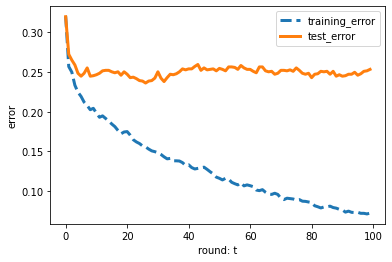

In [30]:
plt.xlabel('round: t')
plt.ylabel('error')
plt.plot(ada_tr_err[::10], label = 'training_error',
        linestyle = 'dashed', lw = 3)
plt.plot(ada_te_err[::10], label = 'test_error',
        linestyle = 'solid', lw = 3)
plt.legend()
plt.show();

In [32]:
import xgboost as xgb

In [33]:
# データをよみこむ
n = 4000
d = pd.read_csv('data/soldat.csv').values; d = np.delete(d, 70, 1)
i = np.random.choice(len(d), n, replace = False)
ti = np.delete(np.arange(len(d)), i)
x, y = d[i, :71], d[i, 71] # トレーニングデータ
tx, ty = d[ti, :71], d[ti, 71] # テストデータ
T = 1000 # ラウンド数:1000
xg = xgb.XGBClassifier(n_estimators = T, max_depth = 1,
                      objective = 'binary:logistic')


In [34]:
xg.fit(x, y)
1 - xg.score(tx, ty) # テスト誤差

/Users/akito_harada/Documents/python/stats/ml/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:46:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.2372777437155119

In [39]:
xg = xgb.XGBClassifier(n_estimators = 1000, max_depth = 1,
                      objective = 'binary:logistic')
cvx = x[:3500, :]
cvy = y[:3500] # トレーニングデータ
eval_set = [(x[3500:, :], y[3500:])] # 検証用のデータ
# verboseを設定: 途中経過をプリント
xg.fit(cvx, cvy, early_stopping_rounds = 10, eval_metric = 'logloss',
      eval_set = eval_set, verbose = True)

[0]	validation_0-logloss:0.64791
[1]	validation_0-logloss:0.63083
[2]	validation_0-logloss:0.61194
[3]	validation_0-logloss:0.60397
[4]	validation_0-logloss:0.59690
[5]	validation_0-logloss:0.59076
[6]	validation_0-logloss:0.59030
[7]	validation_0-logloss:0.58469
[8]	validation_0-logloss:0.58038
[9]	validation_0-logloss:0.57852
[10]	validation_0-logloss:0.57622
[11]	validation_0-logloss:0.57423
[12]	validation_0-logloss:0.57281
[13]	validation_0-logloss:0.57080
[14]	validation_0-logloss:0.56859
[15]	validation_0-logloss:0.56725
[16]	validation_0-logloss:0.56727
[17]	validation_0-logloss:0.56422
[18]	validation_0-logloss:0.56298
[19]	validation_0-logloss:0.56301
[20]	validation_0-logloss:0.56091
[21]	validation_0-logloss:0.55914
[22]	validation_0-logloss:0.55834
[23]	validation_0-logloss:0.55656
[24]	validation_0-logloss:0.55553
[25]	validation_0-logloss:0.55544
[26]	validation_0-logloss:0.55270
[27]	validation_0-logloss:0.55231
[28]	validation_0-logloss:0.55021
[29]	validation_0-loglos

/Users/akito_harada/Documents/python/stats/ml/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[34]	validation_0-logloss:0.54819
[35]	validation_0-logloss:0.54658
[36]	validation_0-logloss:0.54527
[37]	validation_0-logloss:0.54526
[38]	validation_0-logloss:0.54499
[39]	validation_0-logloss:0.54453
[40]	validation_0-logloss:0.54515
[41]	validation_0-logloss:0.54428
[42]	validation_0-logloss:0.54385
[43]	validation_0-logloss:0.54233
[44]	validation_0-logloss:0.54319
[45]	validation_0-logloss:0.54370
[46]	validation_0-logloss:0.54323
[47]	validation_0-logloss:0.54173
[48]	validation_0-logloss:0.54002
[49]	validation_0-logloss:0.53895
[50]	validation_0-logloss:0.53875
[51]	validation_0-logloss:0.53819
[52]	validation_0-logloss:0.53759
[53]	validation_0-logloss:0.53704
[54]	validation_0-logloss:0.53724
[55]	validation_0-logloss:0.53711
[56]	validation_0-logloss:0.53697
[57]	validation_0-logloss:0.53479
[58]	validation_0-logloss:0.53546
[59]	validation_0-logloss:0.53498
[60]	validation_0-logloss:0.53507
[61]	validation_0-logloss:0.53368
[62]	validation_0-logloss:0.53287
[63]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
xg.best_iteration

63

In [41]:
1 - xg.score(tx, ty)

0.25444512568976085

In [42]:
# 予測点における各ラベルの条件付き確率
xg.predict_proba(tx)

array([[0.7627829 , 0.23721711],
       [0.78430164, 0.21569833],
       [0.7871538 , 0.2128462 ],
       ...,
       [0.2973255 , 0.7026745 ],
       [0.23214984, 0.76785016],
       [0.3622679 , 0.6377321 ]], dtype=float32)